In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

In [8]:
pd.options.display.float_format = "{:,.2f}".format

### Generator IDs

In [9]:
gen_id = pd.read_csv('datasets/cleaned/generators_updated.csv', 
            usecols=['Resource Name', 'SUBTYPE', 'TYPE'])
gen_id.head()

,Resource Name,TYPE,SUBTYPE
0,1ACNPC_G01,BIOMASS,Biogas
1,1AMBUK_U01,LARGE HYDROELECTRIC,Dam-type HEPP
2,1AMBUK_U02,LARGE HYDROELECTRIC,Dam-type HEPP
3,1AMBUK_U03,LARGE HYDROELECTRIC,Dam-type HEPP
4,1AMPHAW_G01,SMALL HYDROELECTRIC,Run-of-River type HEPP


In [4]:
# gen_id['SUBTYPE'].unique()

### Generation Loading Datasets

In [10]:
df = pd.read_csv('datasets/cleaned/MW-ante-post2.csv')
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df.head()

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post
0,2009-12-26,0,1AEC_G01,2009-12-26,0.00,0.00,0.00,0.00,-10.13,0.00
1,2009-12-26,0,1ANGAT_A,2009-12-26,25.00,0.00,138.89,24.30,-10.00,135.00
2,2009-12-26,0,1ANGAT_M,2009-12-26,5.00,0.00,2.50,5.00,-10.00,2.50
3,2009-12-26,0,1APEC_G01,2009-12-26,0.00,0.00,0.00,0.00,-10.13,0.00
4,2009-12-26,0,1BAKUN_G01,2009-12-26,0.80,0.00,1.05,0.80,-10.12,1.05


### Installed Plant Capacity

In [11]:
installed_capacity = pd.read_csv('datasets/Purchased-aggregated/08_Registered'
                                 ' Capacities-20210728T054328Z-001/08_Registered Capacities/GENERATOR '
                                 'CAPACITY 20181226-20191225.csv',
                                usecols=['RESOURCE_NAME', 'MW'])
installed_capacity = installed_capacity.groupby('RESOURCE_NAME').max().reset_index()
installed_capacity.to_csv('datasets/cleaned/installed_capacity.csv')
installed_capacity.head()

,RESOURCE_NAME,MW
0,1AEC_G01,27.50
1,1AMBUK_U01,35.00
2,1AMBUK_U02,35.00
3,1AMBUK_U03,35.00
4,1AMPHAW_G01,12.50


### Merge Dataframes

In [12]:
datasets = pd.merge(df, gen_id, 
                    left_on='RESOURCE_NAME', 
                    right_on='Resource Name', 
                    how='left').drop('Resource Name', axis=1)

In [13]:
datasets = pd.merge(datasets, installed_capacity, 
                    on='RESOURCE_NAME', 
                    how='left').rename(columns={'MW':'MW_installed'})
datasets

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed
0,2009-12-26,0,1AEC_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-10.13,0.00,NaN,NaN,27.50
1,2009-12-26,0,1ANGAT_A,2009-12-26 00:00:00,25.00,0.00,138.89,24.30,-10.00,135.00,LARGE HYDROELECTRIC,Dam-type HEPP,18.00
2,2009-12-26,0,1ANGAT_M,2009-12-26 00:00:00,5.00,0.00,2.50,5.00,-10.00,2.50,LARGE HYDROELECTRIC,Dam-type HEPP,200.00
3,2009-12-26,0,1APEC_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-10.13,0.00,COAL,Pulvurized Sub Critical Coal,52.00
4,2009-12-26,0,1BAKUN_G01,2009-12-26 00:00:00,0.80,0.00,1.05,0.80,-10.12,1.05,LARGE HYDROELECTRIC,Run-of-River type HEPP,76.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22085167,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00
22085168,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00
22085169,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00
22085170,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00


In [14]:
# datasets[(datasets['RESOURCE_NAME']=='1CONSOL_G01') & (datasets['DELIVERY_HOUR']==13)]

### Filtering

In [15]:
baseloads = ['COAL', 'NATURAL GAS', 'GEOTHERMAL'] #Set all types of plant to be considered
df_baseloads = datasets[datasets['TYPE'].isin(baseloads)].copy()

In [16]:
variables = ['LARGE HYDROELECTRIC', 'DIESEL', 'BIOMASS',
             'WIND', 'SMALL HYDROELECTRIC', 'MINI HYDROELECTRIC',
             'OIL THERMAL', 'MICRO HYDROELECTRIC', 'GAS TURBINE']
df_variables = datasets[datasets['TYPE'].isin(variables)].copy()

In [17]:
solar = ['SOLAR']
df_solar = datasets[datasets['TYPE'].isin(solar)].copy()

### Histogram of Loading

In [18]:
ranges = [0,.1,25,50,75,101]

def histogram_loading(df):
    
    results = (df.groupby(['RESOURCE_NAME', 
                           df['DATE_TIME'].dt.year, 
                           pd.cut(df['MW_loading_post'], ranges, right=False)])['MW_loading_post']
                .count()
                .to_frame())
    return results

def histogram_loading_solar(df):
    df = df[df['DELIVERY_HOUR'].isin(range(7,17))]
    results = (df.groupby(['RESOURCE_NAME', df['DATE_TIME'].dt.year, 
                           pd.cut(df['MW_loading_post'], ranges, right=False)])['MW_loading_post']
                .count()
                .to_frame())
    return results

In [19]:
histogram_baseloads = histogram_loading(df_baseloads)
histogram_variables = histogram_loading(df_variables)
histogram_solar = histogram_loading_solar(df_solar)

histogram = pd.concat([histogram_baseloads, histogram_variables, histogram_solar])

histogram = histogram.rename_axis(["Resource_Name", "Year", "Ranges"]).reset_index()

histogram['Ranges'] = histogram['Ranges'].astype(str).str.replace("101", "100")
histogram['Ranges'] = histogram['Ranges'].astype(str).str.replace("\.0", "%")
histogram['Ranges'] = histogram['Ranges'].astype(str).str.replace("0.1", "0.1%")

histogram['Percent_Total'] = 100* histogram['MW_loading_post']/histogram.groupby(['Resource_Name', 'Year'])['MW_loading_post'].transform('sum')

(histogram.to_csv('datasets/cleaned/coal_natgas_histogram.csv', index=False))

histogram

<ipython-input-19-f7d8dcf2849b>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  histogram['Ranges'] = histogram['Ranges'].astype(str).str.replace("\.0", "%")
<ipython-input-19-f7d8dcf2849b>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  histogram['Ranges'] = histogram['Ranges'].astype(str).str.replace("0.1", "0.1%")


,Resource_Name,Year,Ranges,MW_loading_post,Percent_Total
0,1ANDA_G01,2009,"[0%, 0.1%)",0,NaN
1,1ANDA_G01,2009,"[0.1%, 25%)",0,NaN
2,1ANDA_G01,2009,"[25%, 50%)",0,NaN
3,1ANDA_G01,2009,"[50%, 75%)",0,NaN
4,1ANDA_G01,2009,"[75%, 100%)",0,NaN
...,...,...,...,...,...
15215,8COSMO_G01,2021,"[0%, 0.1%)",177,10.06
15216,8COSMO_G01,2021,"[0.1%, 25%)",1582,89.94
15217,8COSMO_G01,2021,"[25%, 50%)",0,0.00
15218,8COSMO_G01,2021,"[50%, 75%)",0,0.00


In [20]:
def unavailable_days_baseloads(df):
    grouped_df = (df.groupby(['RESOURCE_NAME','DELIVERY_DATE'])['MW_post']
        .mean().to_frame())
    unavailable_grouped = grouped_df.loc[grouped_df['MW_post'] <= 0.5]
    result = (unavailable_grouped.groupby(['RESOURCE_NAME','DELIVERY_DATE'])['MW_post']
        .count().to_frame())
    return result

In [21]:
df_baseloads

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed
3,2009-12-26,0,1APEC_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-10.13,0.00,COAL,Pulvurized Sub Critical Coal,52.00
14,2009-12-26,0,1MSINLO_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,315.00
15,2009-12-26,0,1MSINLO_G02,2009-12-26 00:00:00,80.00,0.00,23.26,80.00,-9.96,23.26,COAL,Pulvurized Sub Critical Coal,344.00
22,2009-12-26,0,1SUAL_G01,2009-12-26 00:00:00,225.00,0.00,34.78,225.00,-9.97,34.78,COAL,Pulvurized Sub Critical Coal,647.00
23,2009-12-26,0,1SUAL_G02,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,647.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22085167,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00
22085168,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00
22085169,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00
22085170,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00


In [22]:
histogram_unavail_baseloads = unavailable_days_baseloads(df_baseloads).reset_index()
histogram_unavail_baseloads["label_range"] = "Unavailable"
histogram_unavail_baseloads

,RESOURCE_NAME,DELIVERY_DATE,MW_post,label_range
0,1ANDA_G01,2015-05-09,1,Unavailable
1,1ANDA_G01,2015-05-10,1,Unavailable
2,1ANDA_G01,2015-05-11,1,Unavailable
3,1ANDA_G01,2015-05-12,1,Unavailable
4,1ANDA_G01,2015-05-13,1,Unavailable
...,...,...,...,...
47727,8PEDC_U03,2021-05-02,1,Unavailable
47728,8PEDC_U03,2021-06-11,1,Unavailable
47729,8PEDC_U03,2021-06-12,1,Unavailable
47730,8PEDC_U03,2021-06-13,1,Unavailable


In [23]:
#Used to remove the entries that match RESOURCE_NAME & DELIVERY_DATE to get a dataframe of days where the 
#baseloads are available/running
unavail_days_baseloads = histogram_unavail_baseloads.drop("MW_post", axis=1)
unavail_days_baseloads

,RESOURCE_NAME,DELIVERY_DATE,label_range
0,1ANDA_G01,2015-05-09,Unavailable
1,1ANDA_G01,2015-05-10,Unavailable
2,1ANDA_G01,2015-05-11,Unavailable
3,1ANDA_G01,2015-05-12,Unavailable
4,1ANDA_G01,2015-05-13,Unavailable
...,...,...,...
47727,8PEDC_U03,2021-05-02,Unavailable
47728,8PEDC_U03,2021-06-11,Unavailable
47729,8PEDC_U03,2021-06-12,Unavailable
47730,8PEDC_U03,2021-06-13,Unavailable


In [25]:
df_avail_baseload = pd.merge(df_baseloads,unavail_days_baseloads, on = ["RESOURCE_NAME", 'DELIVERY_DATE'], how='outer', indicator = True)
df_avail_baseload = df_avail_baseload[df_avail_baseload['_merge']=='left_only']
df_avail_baseload 

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,label_range,_merge
48,2009-12-26,0,1MSINLO_G02,2009-12-26 00:00:00,80.00,0.00,23.26,80.00,-9.96,23.26,COAL,Pulvurized Sub Critical Coal,344.00,NaN,left_only
49,2009-12-26,1,1MSINLO_G02,2009-12-26 01:00:00,80.00,-207.02,23.26,80.00,-207.10,23.26,COAL,Pulvurized Sub Critical Coal,344.00,NaN,left_only
50,2009-12-26,2,1MSINLO_G02,2009-12-26 02:00:00,80.00,-500.43,23.26,80.00,"-5,091.30",23.26,COAL,Pulvurized Sub Critical Coal,344.00,NaN,left_only
51,2009-12-26,3,1MSINLO_G02,2009-12-26 03:00:00,80.00,"-5,088.92",23.26,80.00,"-5,069.32",23.26,COAL,Pulvurized Sub Critical Coal,344.00,NaN,left_only
52,2009-12-26,4,1MSINLO_G02,2009-12-26 04:00:00,80.00,-206.29,23.26,80.00,-205.81,23.26,COAL,Pulvurized Sub Critical Coal,344.00,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298319,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00,NaN,left_only
5298320,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00,NaN,left_only
5298321,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00,NaN,left_only
5298322,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00,NaN,left_only


### Distribution of Hourly Ramp Rates

In [26]:
col = ["RESOURCE_NAME", "DELIVERY_DATE", "DELIVERY_HOUR", "DATE_TIME", "MW_ante", "PRICE_ante",	"MW_loading_ante", "MW_post", "PRICE_post", "MW_loading_post", "TYPE", "SUBTYPE", "MW_installed"]

In [28]:
def unavailable_hours_baseloads(df):
    result = df.loc[df['MW_post'] <= 0.5]
    return result
unavailable_hrs_baseloads = unavailable_hours_baseloads(df_baseloads)
df_avail_hrs_baseload = pd.merge(df_baseloads,unavailable_hrs_baseloads, on = col, how='outer', indicator = True)
df_avail_hrs_baseload = df_avail_hrs_baseload[df_avail_hrs_baseload['_merge']=='left_only']
df_avail_hrs_baseload 

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,_merge
2,2009-12-26,0,1MSINLO_G02,2009-12-26 00:00:00,80.00,0.00,23.26,80.00,-9.96,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only
3,2009-12-26,0,1SUAL_G01,2009-12-26 00:00:00,225.00,0.00,34.78,225.00,-9.97,34.78,COAL,Pulvurized Sub Critical Coal,647.00,left_only
7,2009-12-26,0,3ILIJAN_G01,2009-12-26 00:00:00,493.00,0.00,82.17,492.90,-9.84,82.15,NATURAL GAS,Combined Cycle Gas Turbine\n(CCGT),600.00,left_only
8,2009-12-26,0,3ILIJAN_G02,2009-12-26 00:00:00,494.80,0.00,82.47,492.90,-9.84,82.15,NATURAL GAS,Combined Cycle Gas Turbine\n(CCGT),600.00,left_only
9,2009-12-26,0,3MKBN_A,2009-12-26 00:00:00,31.00,0.00,24.60,31.00,-9.94,24.60,GEOTHERMAL,Single Flash,126.00,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298319,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00,left_only
5298320,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00,left_only
5298321,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00,left_only
5298322,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00,left_only


In [29]:
unavailable_hrs_baseloads

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed
3,2009-12-26,0,1APEC_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-10.13,0.00,COAL,Pulvurized Sub Critical Coal,52.00
14,2009-12-26,0,1MSINLO_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,315.00
23,2009-12-26,0,1SUAL_G02,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,647.00
31,2009-12-26,0,3CALACA_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.70,0.00,COAL,Pulvurized Sub Critical Coal,300.00
32,2009-12-26,0,3CALACA_G02,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.70,0.00,COAL,Pulvurized Sub Critical Coal,300.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22084981,2021-06-18,1,3BACMAN_U03,2021-06-18 01:00:00,0.00,"2,699.83",0.00,0.00,"2,689.64",0.00,GEOTHERMAL,Single Flash,20.00
22084982,2021-06-18,2,3BACMAN_U03,2021-06-18 02:00:00,0.00,"2,597.18",0.00,0.00,"2,585.31",0.00,GEOTHERMAL,Single Flash,20.00
22084983,2021-06-18,3,3BACMAN_U03,2021-06-18 03:00:00,0.00,"2,681.07",0.00,0.00,"2,588.93",0.00,GEOTHERMAL,Single Flash,20.00
22085028,2021-06-20,0,3BACMAN_U03,2021-06-20 00:00:00,19.00,"20,636.49",95.00,0.00,"18,783.78",0.00,GEOTHERMAL,Single Flash,20.00


In [30]:
unavailable_hrs_baseloads['label_range'] = 'Unavailable'
unavailable_hrs_baseloads

<ipython-input-30-f2cb12ae5ec1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unavailable_hrs_baseloads['label_range'] = 'Unavailable'


,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,label_range
3,2009-12-26,0,1APEC_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-10.13,0.00,COAL,Pulvurized Sub Critical Coal,52.00,Unavailable
14,2009-12-26,0,1MSINLO_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,315.00,Unavailable
23,2009-12-26,0,1SUAL_G02,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.97,0.00,COAL,Pulvurized Sub Critical Coal,647.00,Unavailable
31,2009-12-26,0,3CALACA_G01,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.70,0.00,COAL,Pulvurized Sub Critical Coal,300.00,Unavailable
32,2009-12-26,0,3CALACA_G02,2009-12-26 00:00:00,0.00,0.00,0.00,0.00,-9.70,0.00,COAL,Pulvurized Sub Critical Coal,300.00,Unavailable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22084981,2021-06-18,1,3BACMAN_U03,2021-06-18 01:00:00,0.00,"2,699.83",0.00,0.00,"2,689.64",0.00,GEOTHERMAL,Single Flash,20.00,Unavailable
22084982,2021-06-18,2,3BACMAN_U03,2021-06-18 02:00:00,0.00,"2,597.18",0.00,0.00,"2,585.31",0.00,GEOTHERMAL,Single Flash,20.00,Unavailable
22084983,2021-06-18,3,3BACMAN_U03,2021-06-18 03:00:00,0.00,"2,681.07",0.00,0.00,"2,588.93",0.00,GEOTHERMAL,Single Flash,20.00,Unavailable
22085028,2021-06-20,0,3BACMAN_U03,2021-06-20 00:00:00,19.00,"20,636.49",95.00,0.00,"18,783.78",0.00,GEOTHERMAL,Single Flash,20.00,Unavailable


In [31]:
baseload_resource = df_avail_hrs_baseload["RESOURCE_NAME"].unique()
baseload_resource

array(['1MSINLO_G02', '1SUAL_G01', '3ILIJAN_G01', '3ILIJAN_G02',
       '3MKBN_A', '3MKBN_B', '3MKBN_D', '3MKBN_E', '3PAGBIL_G01',
       '3PAGBIL_G02', '3QPPL_G01', '3STA-RI_G01', '3STA-RI_G02',
       '3STA-RI_G03', '3STA-RI_G04', '3STA-RI_G05', '3STA-RI_G06',
       '3TIWI_A', '3TIWI_C', '4LEYTE_A', '4LGPP_G01', '6PAL1A_G01',
       '1SUAL_G02', '3CALACA_G02', '3CALACA_G01', '1MSINLO_G01',
       '5TPC_G02', '5KSPC_G01', '5KSPC_G02', '3MKBN_C', '1APEC_G01',
       '1MARVEL_G01', '3ORMAT_G01', '1MARVEL_G02', '1PETRON_G01',
       '3MGPP_G01', '6NASULO_G01', '3SLTEC_G01', '1ANDA_G01',
       '3SLPGC_G01', '3SLTEC_G02', '3SLPGC_G02', '3SNGAB_G01',
       '8PALM_G01', '8PEDC_U03', '1SMC_G01', '8PEDC_U01', '8PEDC_U02',
       '3AVION_U01', '3AVION_U02', '5CEDC_U01', '5CEDC_U02', '5CEDC_U03',
       '6PAL2A_U01', '6PAL2A_U02', '6PAL2A_U03', '1SMC_G02', '1UPPC_G01',
       '3PAGBIL_G03', '1SMC_G03', '5THVI_U01', '3MGI_G02', '5THVI_U02',
       '1SMC_G04', '1MSINLO_G03', '3SBPL_G01', '3BACM

In [32]:
d = {}
for name in baseload_resource:
    d[name] = df_avail_hrs_baseload[df_avail_hrs_baseload["RESOURCE_NAME"]==name]

In [33]:
for name, df in d.items():
    df["pct_change"] = abs(df.MW_post.pct_change(periods=1))*100

<ipython-input-33-7c117aa8edcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pct_change"] = abs(df.MW_post.pct_change(periods=1))*100


In [34]:
d['3BACMAN_U03']

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,_merge,pct_change
5215967,2012-01-29,11,3BACMAN_U03,2012-01-29 11:00:00,0.00,"2,875.43",0.00,1.10,"3,628.93",5.50,GEOTHERMAL,Single Flash,20.00,left_only,NaN
5216906,2012-03-08,15,3BACMAN_U03,2012-03-08 15:00:00,0.00,"17,329.03",0.00,0.70,"17,226.23",3.50,GEOTHERMAL,Single Flash,20.00,left_only,36.36
5227719,2013-06-02,14,3BACMAN_U03,2013-06-02 14:00:00,18.00,"2,588.53",90.00,18.00,"2,616.86",90.00,GEOTHERMAL,Single Flash,20.00,left_only,"2,471.43"
5227720,2013-06-02,15,3BACMAN_U03,2013-06-02 15:00:00,18.00,"2,390.46",90.00,18.00,"2,602.55",90.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00
5227721,2013-06-02,16,3BACMAN_U03,2013-06-02 16:00:00,18.00,"2,638.43",90.00,18.00,"2,623.29",90.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298319,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00
5298320,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00,left_only,52.63
5298321,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00
5298322,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00,left_only,111.11


In [35]:
def label_range(row):
    
    if row["pct_change"] == 0:
        return 'No Ramping'
    if row["pct_change"] != 0 and row["pct_change"] <= 2.5:
        return '<2.5%'
    if row["pct_change"] > 2.5:
        return '>2.5%'
    
appended_data =[]

for name, df in d.items():
    appended_data.append(df)
df_pct_change = pd.concat(appended_data)
df_pct_change["label_range"] = df_pct_change.apply(lambda row: label_range(row), axis=1)

In [36]:
df_pct_change

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,_merge,pct_change,label_range
2,2009-12-26,0,1MSINLO_G02,2009-12-26 00:00:00,80.00,0.00,23.26,80.00,-9.96,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,NaN,None
32,2009-12-26,1,1MSINLO_G02,2009-12-26 01:00:00,80.00,-207.02,23.26,80.00,-207.10,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
62,2009-12-26,2,1MSINLO_G02,2009-12-26 02:00:00,80.00,-500.43,23.26,80.00,"-5,091.30",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
92,2009-12-26,3,1MSINLO_G02,2009-12-26 03:00:00,80.00,"-5,088.92",23.26,80.00,"-5,069.32",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
122,2009-12-26,4,1MSINLO_G02,2009-12-26 04:00:00,80.00,-206.29,23.26,80.00,-205.81,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298319,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00,No Ramping
5298320,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00,left_only,52.63,>2.5%
5298321,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00,No Ramping
5298322,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00,left_only,111.11,>2.5%


In [37]:
df_pct_change = df_pct_change[df_pct_change['pct_change'].notna()]

(array([3440660.,   89087.,  135581.,  343420.,   48774.,   14632.]),
 array([  0. ,   2.5,   5. ,  10. ,  50. , 100. , 500. ]),
 <BarContainer object of 6 artists>)

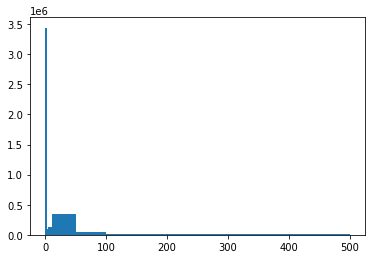

In [38]:
plt.hist(df_pct_change["pct_change"], bins =[0,2.5,5,10,50,100,500])

In [39]:
df_pct_change

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,_merge,pct_change,label_range
32,2009-12-26,1,1MSINLO_G02,2009-12-26 01:00:00,80.00,-207.02,23.26,80.00,-207.10,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
62,2009-12-26,2,1MSINLO_G02,2009-12-26 02:00:00,80.00,-500.43,23.26,80.00,"-5,091.30",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
92,2009-12-26,3,1MSINLO_G02,2009-12-26 03:00:00,80.00,"-5,088.92",23.26,80.00,"-5,069.32",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
122,2009-12-26,4,1MSINLO_G02,2009-12-26 04:00:00,80.00,-206.29,23.26,80.00,-205.81,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
152,2009-12-26,5,1MSINLO_G02,2009-12-26 05:00:00,80.00,-9.96,23.26,80.00,-206.59,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5298319,2021-06-25,19,3BACMAN_U03,2021-06-25 19:00:00,19.00,"4,633.86",95.00,19.00,"4,637.31",95.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00,No Ramping
5298320,2021-06-25,20,3BACMAN_U03,2021-06-25 20:00:00,0.00,"13,556.49",0.00,9.00,"11,316.27",45.00,GEOTHERMAL,Single Flash,20.00,left_only,52.63,>2.5%
5298321,2021-06-25,21,3BACMAN_U03,2021-06-25 21:00:00,9.00,"8,095.88",45.00,9.00,"7,981.14",45.00,GEOTHERMAL,Single Flash,20.00,left_only,0.00,No Ramping
5298322,2021-06-25,22,3BACMAN_U03,2021-06-25 22:00:00,19.00,"3,625.97",95.00,19.00,"3,600.83",95.00,GEOTHERMAL,Single Flash,20.00,left_only,111.11,>2.5%


In [40]:
df_pct_change.isnull().sum()
#df_pct_change.max()

DELIVERY_DATE          0
DELIVERY_HOUR          0
RESOURCE_NAME          0
DATE_TIME              0
MW_ante                0
PRICE_ante             0
MW_loading_ante        0
MW_post                0
PRICE_post             0
MW_loading_post        0
TYPE                   0
SUBTYPE                0
MW_installed       10509
_merge                 0
pct_change             0
label_range            0
dtype: int64

In [41]:
histo_pct_change = pd.concat([df_pct_change, unavailable_hrs_baseloads])
histo_pct_change

,DELIVERY_DATE,DELIVERY_HOUR,RESOURCE_NAME,DATE_TIME,MW_ante,PRICE_ante,MW_loading_ante,MW_post,PRICE_post,MW_loading_post,TYPE,SUBTYPE,MW_installed,_merge,pct_change,label_range
32,2009-12-26,1,1MSINLO_G02,2009-12-26 01:00:00,80.00,-207.02,23.26,80.00,-207.10,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
62,2009-12-26,2,1MSINLO_G02,2009-12-26 02:00:00,80.00,-500.43,23.26,80.00,"-5,091.30",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
92,2009-12-26,3,1MSINLO_G02,2009-12-26 03:00:00,80.00,"-5,088.92",23.26,80.00,"-5,069.32",23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
122,2009-12-26,4,1MSINLO_G02,2009-12-26 04:00:00,80.00,-206.29,23.26,80.00,-205.81,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
152,2009-12-26,5,1MSINLO_G02,2009-12-26 05:00:00,80.00,-9.96,23.26,80.00,-206.59,23.26,COAL,Pulvurized Sub Critical Coal,344.00,left_only,0.00,No Ramping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22084981,2021-06-18,1,3BACMAN_U03,2021-06-18 01:00:00,0.00,"2,699.83",0.00,0.00,"2,689.64",0.00,GEOTHERMAL,Single Flash,20.00,NaN,NaN,Unavailable
22084982,2021-06-18,2,3BACMAN_U03,2021-06-18 02:00:00,0.00,"2,597.18",0.00,0.00,"2,585.31",0.00,GEOTHERMAL,Single Flash,20.00,NaN,NaN,Unavailable
22084983,2021-06-18,3,3BACMAN_U03,2021-06-18 03:00:00,0.00,"2,681.07",0.00,0.00,"2,588.93",0.00,GEOTHERMAL,Single Flash,20.00,NaN,NaN,Unavailable
22085028,2021-06-20,0,3BACMAN_U03,2021-06-20 00:00:00,19.00,"20,636.49",95.00,0.00,"18,783.78",0.00,GEOTHERMAL,Single Flash,20.00,NaN,NaN,Unavailable


In [42]:
def histogram_ramping(df):
    results = df.groupby(['RESOURCE_NAME', df['DATE_TIME'].dt.year, 'label_range'])["MW_post"].count().to_frame()
    return results.reset_index()

histo_pct_change = histogram_ramping(histo_pct_change)

In [43]:
histo_pct_change

,RESOURCE_NAME,DATE_TIME,label_range,MW_post
0,1ANDA_G01,2015,<2.5%,1148
1,1ANDA_G01,2015,>2.5%,536
2,1ANDA_G01,2015,No Ramping,964
3,1ANDA_G01,2015,Unavailable,3004
4,1ANDA_G01,2016,<2.5%,3469
...,...,...,...,...
2491,8PEDC_U03,2020,Unavailable,927
2492,8PEDC_U03,2021,<2.5%,154
2493,8PEDC_U03,2021,>2.5%,1074
2494,8PEDC_U03,2021,No Ramping,2267


In [44]:
def yearly_ramping_percentage(df):
    df["pct_instance"] = 100*df['MW_post']/df.groupby(["RESOURCE_NAME", "DATE_TIME"])['MW_post'].transform('sum')
    return df
histo_pct_change = yearly_ramping_percentage(histo_pct_change)

In [45]:
histo_pct_change.to_csv('datasets/cleaned/histo_hourly_ramping.csv')

### Histogram Variance Loading

In [46]:
ranges = [0,.1,30,50000]

def label_range(row):
    
    if str(row["Ranges"]) =="[0.0, 0.1)":
        return 'Baseload'
    if str(row["Ranges"]) =="[0.1, 30.0)":
        return 'Less than 30% Variance'
    if str(row["Ranges"]) =="[30.0, 50000.0)":
        return 'More than 30% Variance'

def histogram_daily_variance(df):
    
    histogram_day_variance = (df.groupby(['RESOURCE_NAME','DELIVERY_DATE'])['MW_loading_post']
     .var().to_frame())
    
    histogram_day_variance = (histogram_day_variance.groupby(['RESOURCE_NAME', 'DELIVERY_DATE', 
                               pd.cut(histogram_day_variance['MW_loading_post'], ranges, right=False)])['MW_loading_post']
                    .count()
                    .to_frame())
    results = histogram_day_variance.rename_axis(["Resource_Name", "Date", "Ranges"]).reset_index()
    results['label_range'] = results.apply(lambda row: label_range(row), axis=1)
    
    return results

In [47]:
histogram_avail_baseload = histogram_daily_variance(df_avail_baseload)
histogram_avail_baseload

,Resource_Name,Date,Ranges,MW_loading_post,label_range
0,1ANDA_G01,2009-12-26,"[0.0, 0.1)",0,Baseload
1,1ANDA_G01,2009-12-26,"[0.1, 30.0)",0,Less than 30% Variance
2,1ANDA_G01,2009-12-26,"[30.0, 50000.0)",0,More than 30% Variance
3,1ANDA_G01,2009-12-27,"[0.0, 0.1)",0,Baseload
4,1ANDA_G01,2009-12-27,"[0.1, 30.0)",0,Less than 30% Variance
...,...,...,...,...,...
856795,8PEDC_U03,2021-06-24,"[0.1, 30.0)",0,Less than 30% Variance
856796,8PEDC_U03,2021-06-24,"[30.0, 50000.0)",1,More than 30% Variance
856797,8PEDC_U03,2021-06-25,"[0.0, 0.1)",0,Baseload
856798,8PEDC_U03,2021-06-25,"[0.1, 30.0)",1,Less than 30% Variance


In [48]:
histogram = pd.concat([histogram_avail_baseload, histogram_unavail_baseloads.
                       rename(columns = {'RESOURCE_NAME':'Resource_Name','DELIVERY_DATE':'Date','MW_post':'MW_loading_post'})])
histogram

,Resource_Name,Date,Ranges,MW_loading_post,label_range
0,1ANDA_G01,2009-12-26,"[0.0, 0.1)",0,Baseload
1,1ANDA_G01,2009-12-26,"[0.1, 30.0)",0,Less than 30% Variance
2,1ANDA_G01,2009-12-26,"[30.0, 50000.0)",0,More than 30% Variance
3,1ANDA_G01,2009-12-27,"[0.0, 0.1)",0,Baseload
4,1ANDA_G01,2009-12-27,"[0.1, 30.0)",0,Less than 30% Variance
...,...,...,...,...,...
47727,8PEDC_U03,2021-05-02,NaN,1,Unavailable
47728,8PEDC_U03,2021-06-11,NaN,1,Unavailable
47729,8PEDC_U03,2021-06-12,NaN,1,Unavailable
47730,8PEDC_U03,2021-06-13,NaN,1,Unavailable


In [49]:
histogram.to_csv('datasets/cleaned/histo_day_variance.csv')

In [51]:
len(set(gen_id['Resource Name']))
#len(set(installed_capacity['RESOURCE_NAME']))
#len(set(df['RESOURCE_NAME']))

374

In [52]:
histogram[histogram['Resource_Name']=="8STBPB2_U02"]

,Resource_Name,Date,Ranges,MW_loading_post,label_range


### Availability heat map

In [53]:
def unavailability_days_baseloads(x):
    try:
        return len(x[x <= 0.5]) / 24
    except:
        return 0
    
def unavailability_days_variables(x):
    try:
        return len(x[x == 0]) / 24
#         return len(x[x <= 0.1]) / 24    
    except:
        return 0   
    
def unavailability_days_solar(x):
    try:
        return len(x[x == 0]) / 10    #since only 10 hours in a day is considered
#         return len(x[x <= 0.1]) / 10     
    except:
        return 0  

In [67]:
def unavailability_days_yearly_baseloads():
    result = pd.DataFrame()
    for year in range(2021, 2009, -1):
        result[str(year)] = (df_baseloads[df_baseloads['DATE_TIME'].dt.year==year]
                                .groupby(['TYPE', 'SUBTYPE', 'RESOURCE_NAME'])['MW_post']
                                .apply(unavailability_days_baseloads))
    return result

def unavailability_days_yearly_variables():
    result = pd.DataFrame()
    for year in range(2021, 2009, -1):
        result[str(year)] = (df_variables[df_variables['DATE_TIME'].dt.year==year]
                                .groupby(['TYPE', 'SUBTYPE', 'RESOURCE_NAME'])['MW_post']
                                .apply(unavailability_days_variables))
    return result

def unavailability_days_yearly_solar():
    result = pd.DataFrame()
    for year in range(2021, 2009, -1):
        result[str(year)] = (df_solar[(df_solar['DATE_TIME'].dt.year==year) &
                                      (df_solar['DELIVERY_HOUR'].isin(range(7,17)))]
                                .groupby(['TYPE', 'SUBTYPE', 'RESOURCE_NAME'])['MW_post']
                                .apply(unavailability_days_solar))
    return result

In [68]:
unavail_hr_baseloads = unavailability_days_yearly_baseloads()
unavail_hr_variables = unavailability_days_yearly_variables()
unavail_hr_solar = unavailability_days_yearly_solar()

unavail_hr = pd.concat([unavail_hr_baseloads, unavail_hr_variables, unavail_hr_solar])

In [69]:
unavail_hr

2021  \
TYPE  SUBTYPE                                            RESOURCE_NAME          
COAL  Circularized Fluidized Bed (CFB)\nCoal Co-gener... 1UPPC_G01     175.88   
      Circulating Fluidized Bed (CFB)\nCoal              1ANDA_G01      19.08   
                                                         1SMC_G01        0.00   
                                                         1SMC_G02        7.50   
                                                         1SMC_G03        0.96   
...                                                                       ...   
SOLAR Ground Mounted Solar PVs                           6SACSUN_G01     2.20   
                                                         6SLYSOL_G01     3.50   
                                                         8COSMO_G01     17.70   
      Rooftop Installed Solar PVs                        2SMNRTH_G01     0.00   
                                                         3MEC_G01       73.30   

                                                                         2020  \
TYPE  SUBTYPE                                            RESOURCE_NAME          
COAL  Circularized Fluidized Bed (CFB)\nCoal Co-gener... 1UPPC_G01     366.00   
      Circulating Fluidized Bed (CFB)\nCoal              1ANDA_G01      99.08   
                                                         1SMC_G01       51.88   
                                                         1SMC_G02       37.79   
                                                         1SMC_G03       87.38   
...                                                                       ...   
SOLAR Ground Mounted Solar PVs                           6SACSUN_G01     1.30   
                                                         6SLYSOL_G01    28.90   
                                                         8COSMO_G01     30.60   
      Rooftop Installed Solar PVs                        2SMNRTH_G01     0.00   
                                                         3MEC_G01       91.30   

                                                                         2019  \
TYPE  SUBTYPE                                            RESOURCE_NAME          
COAL  Circularized Fluidized Bed (CFB)\nCoal Co-gener... 1UPPC_G01     364.71   
      Circulating Fluidized Bed (CFB)\nCoal              1ANDA_G01      21.92   
                                                         1SMC_G01       77.62   
                                                         1SMC_G02       72.67   
                                                         1SMC_G03       50.92   
...                                                                       ...   
SOLAR Ground Mounted Solar PVs                           6SACSUN_G01     2.10   
                                                         6SLYSOL_G01     4.10   
                                                         8COSMO_G01     33.30   
      Rooftop Installed Solar PVs                        2SMNRTH_G01     0.00   
                                                         3MEC_G01       22.70   

                                                                         2018  \
TYPE  SUBTYPE                                            RESOURCE_NAME          
COAL  Circularized Fluidized Bed (CFB)\nCoal Co-gener... 1UPPC_G01     364.96   
      Circulating Fluidized Bed (CFB)\nCoal              1ANDA_G01      46.58   
                                                         1SMC_G01       35.71   
                                                         1SMC_G02       50.54   
                                                         1SMC_G03       31.96   
...                                                                       ...   
SOLAR Ground Mounted Solar PVs                           6SACSUN_G01    31.10   
                                                         6SLYSOL_G01     8.70   
                                                         8COSMO_G01     17.80   
      Rooftop Instal

In [70]:
unavail_hr.to_csv('datasets/cleaned/unavail_hr.csv')